# Work With Standardized Spectral File For ESSP4
Standardized spectra have filenames of the form: `DS#.###_spec_<<inst>>.fits`

For example, the twelfth (012) observation from data set three (3), taken by the HARPS-N instrument will have the file name: `DS3.012_spec_harpsn.fits`

Please see the [ESSP website](https://essp-eprv.github.io/data.html#spectra) for more information

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
# Specify file name
# Specify where all the spectra are saved
spec_dir = 
# For example, to return all files in a data set:
file_list = glob(os.path.join(spec_dir,'*.fits'))

# Select a file at random from all files in the data set as example
file = np.random.choice(file_list)

In [3]:
hdus = fits.open(file)
hdus.info()

Filename: /mnt/home/lzhao/ceph/SolarData/DataSets/Training/DS0/Spectra/DS0.030_spec_harps.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      21   ()      
  1  WAVELENGTH    1 ImageHDU         8   (4096, 73)   float64   
  2  FLUX          1 ImageHDU         8   (4096, 73)   float32   
  3  UNCERTAINTY    1 ImageHDU         8   (4096, 73)   float32   
  4  CONTINUUM     1 ImageHDU         8   (4096, 73)   float64   
  5  BLAZE         1 ImageHDU         8   (4096, 73)   float32   
  6  COMMON_MASK    1 ImageHDU         8   (4096, 73)   int64   
  7  TELLURIC_MASK    1 ImageHDU         8   (4096, 73)   int64   


Each extension is described on the [ESSP website](https://essp-eprv.github.io/data.html#spectra)

In [4]:
# Each data array has shape (number of orders, number of pixels)
num_ord, num_pix = hdus['wavelength'].data.shape

In [5]:
# Header information contained in the header of the primary HDU
hdus[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
INSTRUME= 'HARPS   '           / Instrument name                                
PROGRAM = 'ESSP4   '           / ESSP round                                     
DATA-SET= 'DS0     '           / Name of ESSP4 data set                         
FILENAME= 'DS0.030_spec_harps.fits' / Name of the FITS file                     
DATE    = '2025-05-05T13:02:01.231' / Time of last file modification            
MJD_UTC =    59336.17608674405 / Photon-weighted modified Julian date           
JD_UTC  =    2459336.676086744 / Photon-weighted Julian date                    
EXPTIME =              29.9965 / Exposure time [s]                              
OBSERVAT= 'TEST    '        

## Continuum Normalized Spectra

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


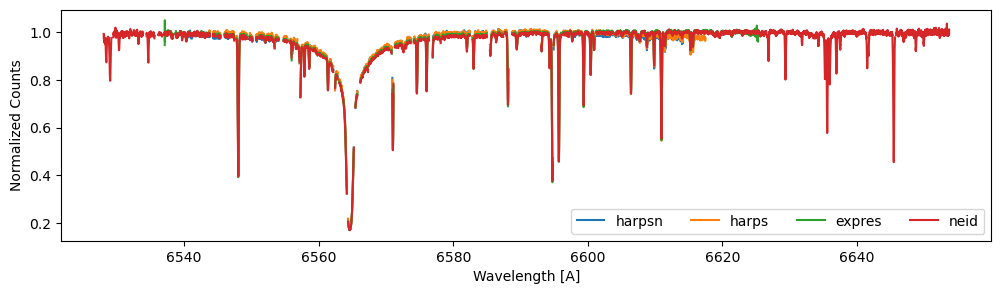

In [6]:
# Plot Echelle Order 93 (i.e. Standard Relative Order 161-93=68)
nord = 161-93

plt.figure(figsize=(12,3))
plt.xlabel('Wavelength [A]')
plt.ylabel('Normalized Counts')
for inst in ['harpsn','harps','expres','neid']:
    # Select a random file for each instrument
    file = np.random.choice(glob(os.path.join(spec_dir,f'*_{inst}.fits')))
    hdus = fits.open(file)
    wave = hdus['wavelength'].data.copy()
    spec = hdus['flux'].data.copy()
    cont = hdus['continuum'].data.copy()
    hdus.close()
    
    plt.plot(wave[nord],spec[nord]/cont[nord],label=inst)
    hdus.close()
plt.legend(loc=4,ncol=4)

## Remove Orders With Only NaNs
Here is a simple function for finding which orders have been added and contain only NaNs.  This is demonstrated by employing the resultant mask on an example file from each of the four instruments and printing out the shape of the resultant array with and without the mask.

In [7]:
def getNanMask(flux):
    return np.sum(np.isfinite(hdus['wavelength'].data),axis=1)>0

In [8]:
# The below loop prints the shape of the resultant data array
#     before/after applying the NaN mask
for inst in ['harpsn','harps','expres','neid']:
    # Select a random file for each instrument
    file = np.random.choice(glob(os.path.join(spec_dir,f'*_{inst}.fits')))
    hdus = fits.open(file)
    # Read in the original flux values
    og_flux = hdus['flux'].data
    # Get mask and apply to og_flux array
    flux = og_flux[getNanMask(og_flux)]
    # Compare the shape of the original and masked flux arrays
    print(inst)
    print('Original Array Shape: ',og_flux.shape)
    print('Masked Array Shape: ',flux.shape)
    print('--------------------------------')
    hdus.close()

harpsn
Original Array Shape:  (73, 4096)
Masked Array Shape:  (69, 4096)
--------------------------------
harps
Original Array Shape:  (73, 4096)
Masked Array Shape:  (71, 4096)
--------------------------------
expres
Original Array Shape:  (87, 7920)
Masked Array Shape:  (85, 7920)
--------------------------------
neid
Original Array Shape:  (93, 9216)
Masked Array Shape:  (93, 9216)
--------------------------------


## Uncertainty
You can use the `blaze` to recover the original counts of each spectrum.  You will also notice that the uncertainty, which is reported slightly differently by each instrument's DRP, is approximately the square root of the original counts of each spectrum.

This Means:
1) For weighting spectral values by photon noise, use the blaze keyword; otherwise use the given uncertainties.
1) When using the uncertainty values in a situation in which absolute value matters, be sure to scale the uncertainties how the spectral values are scaled (e.g., if the spectrum is continuum normalized, also continuum normalize the uncertainties)

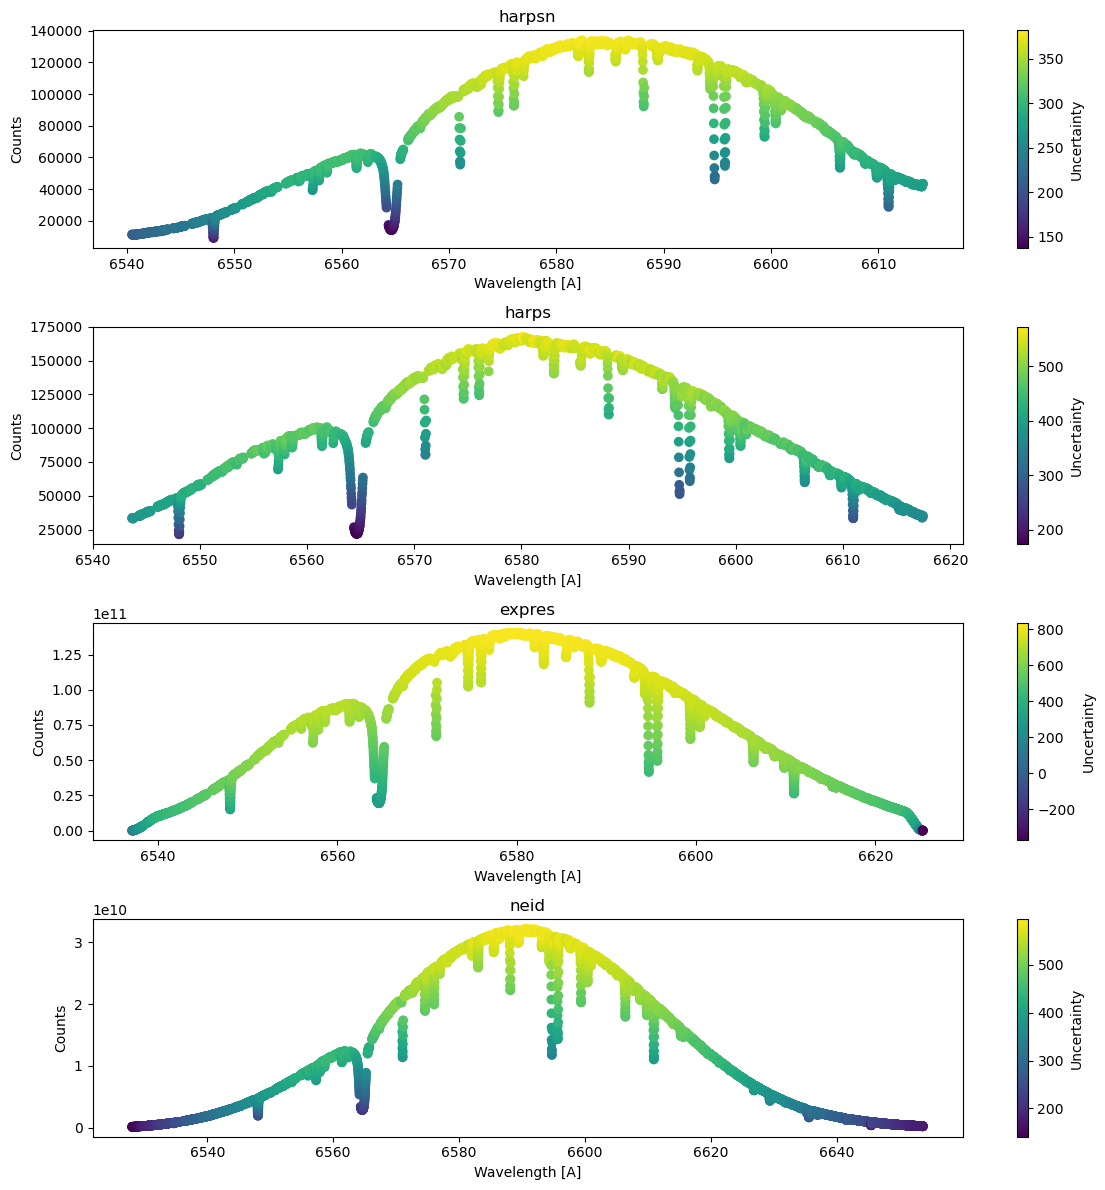

In [9]:
# Plot Echelle Order 93 (i.e. Standard Relative Order 161-93=68)
nord = 161-93

fig, axes = plt.subplots(4,1,figsize=(12,12))
for iinst,inst in enumerate(['harpsn','harps','expres','neid']):
    # Set up a subplot for each instrument
    ax = axes[iinst]
    ax.set_title(inst)
    ax.set_xlabel('Wavelength [A]')
    ax.set_ylabel('Counts')
    # Select a random file for each instrument
    file = np.random.choice(glob(os.path.join(spec_dir,f'*_{inst}.fits')))
    hdus = fits.open(file)
    wave = hdus['wavelength'].data.copy()
    spec = hdus['flux'].data.copy()
    unct = hdus['uncertainty'].data.copy() # read in uncertainties
    blaz = hdus['blaze'].data.copy()
    hdus.close()
    
    cbar = ax.scatter(wave[nord],(spec[nord]*blaz[nord]),c=unct[nord])
    fig.colorbar(cbar,ax=ax,label='Uncertainty')
fig.tight_layout()

## Wavelengths Common to All Four Instruments

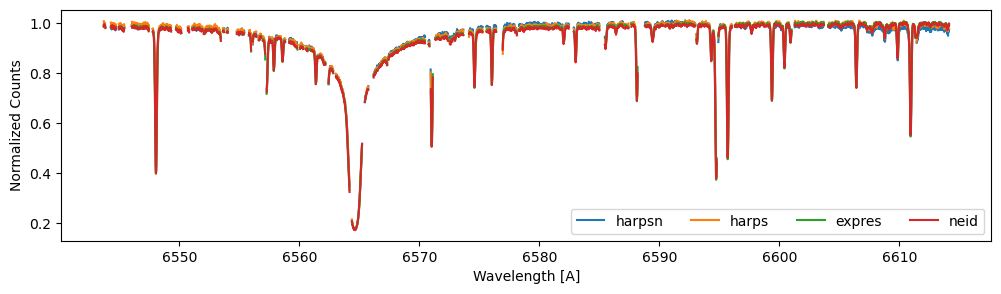

In [10]:
# Plot Echelle Order 93 (i.e. Standard Relative Order 161-93=68)
nord = 161-93

plt.figure(figsize=(12,3))
plt.xlabel('Wavelength [A]')
plt.ylabel('Normalized Counts')
for inst in ['harpsn','harps','expres','neid']:
    # Select a random file for each instrument
    file = np.random.choice(glob(os.path.join(spec_dir,f'*_{inst}.fits')))
    hdus = fits.open(file)
    wave = hdus['wavelength'].data.copy()
    spec = hdus['flux'].data.copy()
    cont = hdus['continuum'].data.copy()
    # Read in mask of common wavelengths
    cmask = hdus['common_mask'].data.astype(bool).copy()
    hdus.close()
    
    nord_mask = cmask[nord] # specify common wavelength mask for the order
    plt.plot(wave[nord][nord_mask],(spec[nord]/cont[nord])[nord_mask],label=inst)
    hdus.close()
plt.legend(loc=4,ncol=4)

## Telluric Mask
The `telluric_mask` data product is 1 where the spectrum has been masked out becasue of the presence of tellurics.  In other words, wherever `telluric_mask` is 1, the spectrum is a `NaN`.  The below figure demonstrates this.

The inverse of `telluric_mask` can be used to return only values in an order with true values.

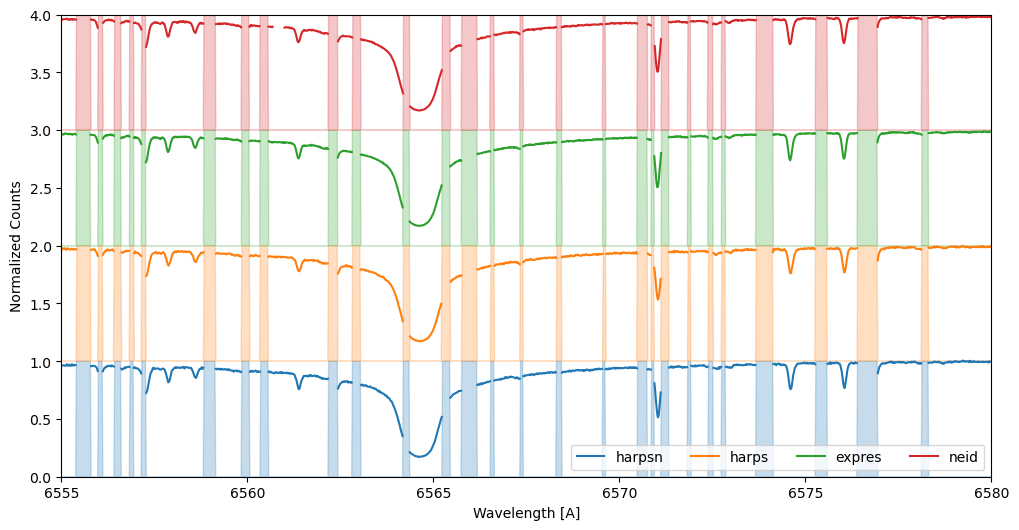

In [11]:
# Plot Echelle Order 93 (i.e. Standard Relative Order 161-93=68)
nord = 161-93

plt.figure(figsize=(12,6))
plt.xlabel('Wavelength [A]')
plt.ylabel('Normalized Counts')
for iinst,inst in enumerate(['harpsn','harps','expres','neid']):
    file = np.random.choice(glob(os.path.join(spec_dir,f'*_{inst}.fits')))
    hdus = fits.open(file)
    wave = hdus['wavelength'].data.copy()
    spec = hdus['flux'].data.copy()
    cont = hdus['continuum'].data.copy()
    tmask = hdus['telluric_mask'].data.copy()
    hdus.close()
    
    plt.plot(wave[nord],spec[nord]/cont[nord]+iinst,label=inst)
    plt.fill_between(wave[nord],iinst,iinst+tmask[nord],color=f'C{iinst}',alpha=0.25)
plt.xlim(6555,6580)
plt.ylim(0,4)
plt.legend(loc=4,ncol=4)